<a href="https://colab.research.google.com/github/Hamxea/Experiments/blob/master/Multi_Label_Classification_Without_Pre_trained_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Text Classification of Text Document or News


 ### DATASET

Toxic Comment Classification dataset. a multi-label text classfication data consisting of many wikipedia comments which have been labeled by humans according to their relative toxicity comments labels such as "toxic", "severe_toxic", "obscene", "threat", "insult", and  "identity_hate". The dataset has approximately ~160k observation in total, ~125k with zero labels (toxicity) of any type, and approximately ~35k classified in one or more toxicity categories.




*   Dataset Link: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge





#### DATA CHARACTERISTICS (TRAIN DATASET)
* Number of data points	159571
* Number data points of type toxic	15294
* Number data points of type severe_tocic	1595
* Number data points of type obscene	8449
* Number data points of type threat	478
* Number data points of type insult	7877
* Number data points of type identity_hate	1405
* Observations in one or more class	35098
* Unclassified observation	124473


### Import necessary libraries for the experiment

In [20]:
# importing libraries
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.model_selection  import train_test_split
#from sklearn.cross_validation import train_test_split


# For custom metrics
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 


import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt

plt.style.use('seaborn')

import seaborn as sns
from IPython.display import Image

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from nltk.tokenize import word_tokenize
import string
import gensim
import os
import re

sns.set_style("whitegrid")
np.random.seed(0)

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='hamzasharoon', api_key='9le0c8M5GUNRAKyJoIt2')


# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Double check with Python 3


In [0]:
#from google.colab import files
#uploaded = files.upload()

#from google.colab import drive
#!kaggle competitions download -c Toxic Comment Classification Challenge -p /content/gdrive/My\ Drive/kaggle/Colab Notebooks/Dataset

### Loading the necessary data files and data Preparation

In [22]:
#Train data
train = pd.read_csv('train.csv')
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


### Clean the Train data, specifically remove punctuations

In [23]:
totalContentCleaned = []
punctDict = {}
for punct in string.punctuation:
    punctDict[punct] = None
transString = str.maketrans(punctDict)
# since we intent to remove any punctuation with ''
for sen in train['comment_text']:
    
    #cleanedString = re.sub('[^a-zA-Z]+', '', sen)
    
    p = sen.translate(transString)
    totalContentCleaned.append(p)
    

train['comment_text'] = totalContentCleaned
# we can save the file to csv if we want in local machine
#df.to_csv(os.path.join(os.path.abspath('data'), 'train_cleaned.csv'), index = False)



train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,Daww He matches this background colour Im seem...,0,0,0,0,0,0
2,000113f07ec002fd,Hey man Im really not trying to edit war Its j...,0,0,0,0,0,0
3,0001b41b1c6bb37e,\nMore\nI cant make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0
5,00025465d4725e87,\n\nCongratulations from me as well use the to...,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [24]:
#Test data
df_test = pd.read_csv('test.csv')
df_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


### Clean the Test data, specifically remove punctuations

In [25]:
totalContentCleaned = []
punctDict = {}
for punct in string.punctuation:
    punctDict[punct] = None
transString = str.maketrans(punctDict)
# since we intent to remove any punctuation with ''
for sen in df_test['comment_text']:
    
    #cleanedString = re.sub('[^a-zA-Z]+', '', sen)
    
    p = sen.translate(transString)
    totalContentCleaned.append(p)
    

df_test['comment_text'] = totalContentCleaned
# we can save the file to csv if we want in local machine
#df.to_csv(os.path.join(os.path.abspath('data'), 'train_cleaned.csv'), index = False)



df_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then youll ...
1,0000247867823ef7,From RfC \n\n The title is fine as it is IMO
2,00013b17ad220c46,\n\n Sources \n\n Zawe Ashton on Lapland —...
3,00017563c3f7919a,If you have a look back at the source the info...
4,00017695ad8997eb,I dont anonymously edit articles at all
5,0001ea8717f6de06,Thank you for understanding I think very highl...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia Such e...
7,000247e83dcc1211,Dear god this site is horrible
8,00025358d4737918,\n Only a fool can believe in such numbers \n...
9,00026d1092fe71cc,Double Redirects \n\n When fixing double red...


In [26]:
df_test_labels = pd.read_csv('test_labels.csv')

df_test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [27]:
test_labels = df_test_labels[(df_test_labels[['toxic','severe_toxic', 'obscene', 'threat', 
                                        'insult', 'identity_hate']] != -1).all(axis=1)]
test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
16,000663aff0fffc80,0,0,0,0,0,0
17,000689dd34e20979,0,0,0,0,0,0
19,000844b52dee5f3f,0,0,0,0,0,0
21,00091c35fa9d0465,1,0,0,0,0,0
22,000968ce11f5ee34,0,0,0,0,0,0


### Merge the df_test and test_labels into 1 dataframe (test)

In [28]:
#Merge the df_test and test_labels into 1 dataframe (test)
test = pd.merge(test_labels, df_test, on='id', how='inner')
test.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding I think very highl...
1,000247e83dcc1211,0,0,0,0,0,0,Dear god this site is horrible
2,0002f87b16116a7f,0,0,0,0,0,0,Somebody will invariably try to add Religion ...
3,0003e1cccfd5a40a,0,0,0,0,0,0,\n\n It says it right there that it IS a type...
4,00059ace3e3e9a53,0,0,0,0,0,0,\n\n Before adding a new product to the list...
5,000663aff0fffc80,0,0,0,0,0,0,this other one from 1897
6,000689dd34e20979,0,0,0,0,0,0,Reason for banning throwing \n\n This articl...
7,000844b52dee5f3f,0,0,0,0,0,0,blocked from editing Wikipedia
8,00091c35fa9d0465,1,0,0,0,0,0,Arabs are committing genocide in Iraq but no ...
9,000968ce11f5ee34,0,0,0,0,0,0,Please stop If you continue to vandalize Wikip...


### Number of records in the train and test data

In [29]:
print("Train data shape", train.shape)
print("Test data shape", test.shape)

Train data shape (159571, 8)
Test data shape (63930, 8)


In [30]:
# check that there are no missing values in either training set
print('The dataset has', train.isna().sum().sum(), 'missing values in train data.')
print('The dataset has', test.isna().sum().sum(), 'missing values in test data.')

# check if there are any duplicates
print('The dataset has', train.duplicated().sum(), 'duplicates in train data.')
print('The dataset has', test.duplicated().sum(), 'duplicates in test data.')

The dataset has 0 missing values in train data.
The dataset has 0 missing values in test data.
The dataset has 0 duplicates in train data.
The dataset has 0 duplicates in test data.


### CORRELATION BETWEEN DATA LABELS

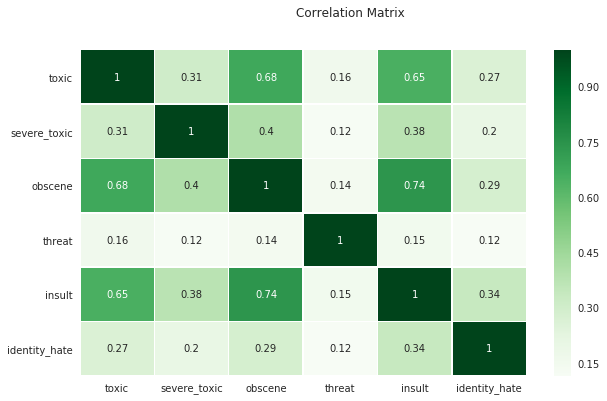

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix')
sns.heatmap(train.corr(), annot=True, cmap="Greens", linewidths=.5, ax=ax);

The correlation figure below shows that Toxic" comments are clearly correlated with both "obscene" and "insult" comments. Interestingly, "toxic" and "severe_toxic" are only weakly correlated. While we can also observe that, "Obscene" comments and "insult" comments are also highly correlated, which makes perfect sense.

### DATA PREPROCESSING
Deep Neural Networks input layers make use of input variables to feed the network for training the model. But in this task (experiment), we're dealing with words text. How do we represent these words in order to feed our model?

In our experiment, we used densed representation of those text (comments) and their semanticity together. The advantage of using this approach is the best way for fitting neural networks onto a text data (as in our case), as well as less memory usage compared to other sparse representation approaches.


#### Word Embedding
Two ways to feed embeddings to neural networks:
   * Using your own word embeddings by training
   * Using pre-trained embedding (e.g Word2vec, lad2vec, Glove etc)
   


In [0]:
#Convert text to vectors using keras preprocessing library tools

X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values






For the first embedding, we used keras preprocessing (Text Preprocessing) libraries. This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf

In [0]:
num_words = 20000 #Max. workds to use per toxic comment
max_features = 200000 #Max. number of unique words in embeddinbg vector
max_len = 200 #Max. number of words per toxic comment to be use
embedding_dims = 128 #embedding vector output dimension 
num_epochs = 1 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.1
batch_size2 = 256 #(before 32)The **batch size** is the number of training examples in one forward/backward pass.
                  # In general, larger batch sizes result in faster progress in training, but don't always converge as quickly. 
                  #Smaller batch sizes train slower, but can converge faster. And the higher the batch size, the more memory space you’ll need.

In [34]:
#toxic comments Tokenization
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized toxic commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = sequence.pad_sequences(X_train, max_len)
X_test  = sequence.pad_sequences(X_test,  max_len)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (159571, 200)
X_test shape:  (63930, 200)


##We use cross validation to split arrays or matrices of train data into random train and validation subsets

In [35]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, train_size =0.9, random_state=233)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



# METHODS (NN, CNN , RNN, LSTM, without pre-trained embedding)

#### We used early callback functionality that allows you to specify the performance measure to monitor, the trigger, and once triggered. It will stop the training process.

In [0]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

#### Using Precision, Recall, F1-Measure, AUC, mean etc evaluaiton metrics to evaluate our model

In [0]:
#Import necessary libraries
4# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  #Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)


fscore = f1score = fmeasure

## 1) Neural Network (NN)

In [38]:
nn_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dropout(0.3),
    Dense(6, activation = 'sigmoid')
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Compile the NN model

In [39]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)


nn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Visualize the Orchestrated NN Architecture

In [40]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 25,606,756
Trainable params: 25,606,756
Non-trainable params: 0
_________________________________________________________________


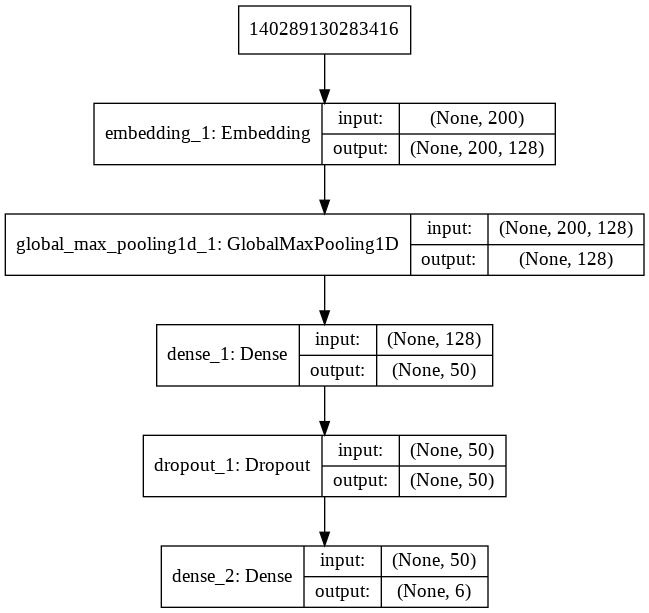

In [41]:
#plot the nn_model architecture

plot_model(nn_model, to_file='nn_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='nn_model_plot.png')

In [42]:
nn_model_fit = nn_model.fit(X_tra, y_tra, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Instructions for updating:
Use tf.cast instead.
Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 439s 3ms/step - loss: 0.0864 - acc: 0.9731 - mean_pred: 0.0412 - fmeasure: 0.4678 - precision: 0.6646 - auroc: 0.8429 - recall: 0.3928 - val_loss: 0.0539 - val_acc: 0.9806 - val_mean_pred: 0.0380 - val_fmeasure: 0.6929 - val_precision: 0.8333 - val_auroc: 0.9372 - val_recall: 0.5968


### Evaluate the NN accuracy of our trained model

In [43]:
nn_train_score = nn_model.evaluate(X_tra, y_tra, batch_size = batch_size2, verbose = 1)
print('Train loss:', nn_train_score[0])
print('Train accuracy:', nn_train_score[1])

143613/143613 [==============================] - 23s 157us/step
Train loss: 0.047640824008828464
Train accuracy: 0.9820605918666393


### Evaluate the NN accuracy base on the test dataset

In [44]:
nn_test_score = nn_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', nn_test_score[0])
print('Test Accuracy:', nn_test_score[1])

63930/63930 [==============================] - 10s 162us/step
Test Loss: 0.07573776019024174
Test Accuracy: 0.9707101609791535


In [45]:
#Predicting......
print('Predicting....')
y_pred = nn_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 8s 121us/step


### Plot Training & Validation Accuracy with the Loss values of the NN Model

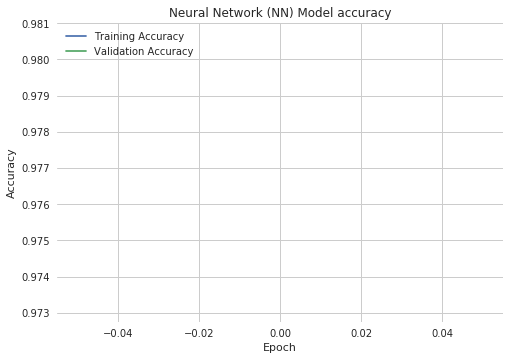

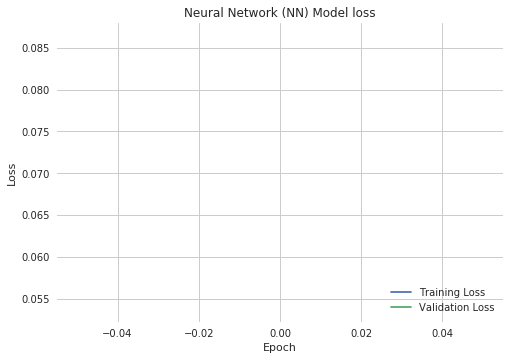

In [46]:
# Plot training & validation accuracy values
plt.plot(nn_model_fit.history['acc'])
plt.plot(nn_model_fit.history['val_acc'])
plt.title('Neural Network (NN) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(nn_model_fit.history['loss'])
plt.plot(nn_model_fit.history['val_loss'])
plt.title('Neural Network (NN) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## 2) Convolutional Neural Network (CNN)

In [0]:
CNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

CNN_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

### Visualize the Orchestrated CNN MODEL Architecture

In [49]:
CNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 100)          51300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 100)          400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
__________

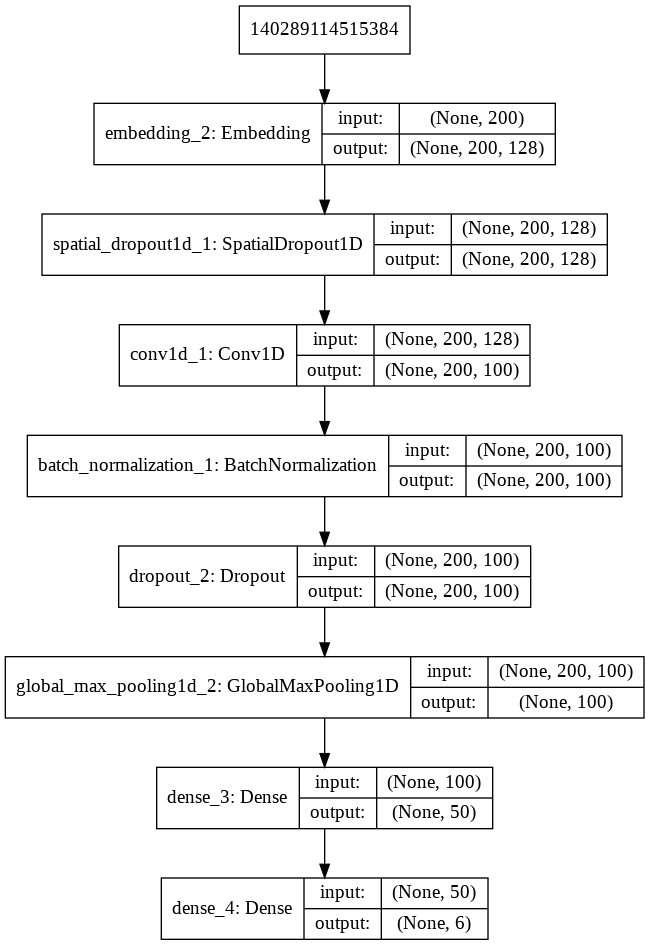

In [50]:
#plot the CNN model architecture

plot_model(CNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_model_plot.png')

In [51]:
CNN_model_fit = CNN_model.fit(X_tra, y_tra, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 1165s 8ms/step - loss: 0.0854 - acc: 0.9748 - mean_pred: 0.0388 - fmeasure: 0.6047 - precision: 0.7400 - auroc: 0.8841 - recall: 0.5309 - val_loss: 0.0655 - val_acc: 0.9804 - val_mean_pred: 0.0527 - val_fmeasure: 0.6931 - val_precision: 0.8171 - val_auroc: 0.9379 - val_recall: 0.6055


### Evaluate the CNN Model accuracy of our trained model

In [52]:
CNN_train_score = CNN_model.evaluate(X_tra, y_tra, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_train_score[0])
print('Train accuracy:', CNN_train_score[1])

143613/143613 [==============================] - 228s 2ms/step
Train loss: 0.059755718891697195
Train accuracy: 0.9818923148691658


### Evaluate the CNN accuracy base our test samples

In [53]:
CNN_test_score = CNN_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_test_score[0])
print('Test Accuracy:', CNN_test_score[1])

63930/63930 [==============================] - 103s 2ms/step
Test Loss: 0.09126898966287944
Test Accuracy: 0.9699645545324883


In [54]:
#Predicting......
print('Predicting....')
y_pred = CNN_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 100s 2ms/step


### Plot Training & Validation Accuracy with the Loss values of the CNN Model

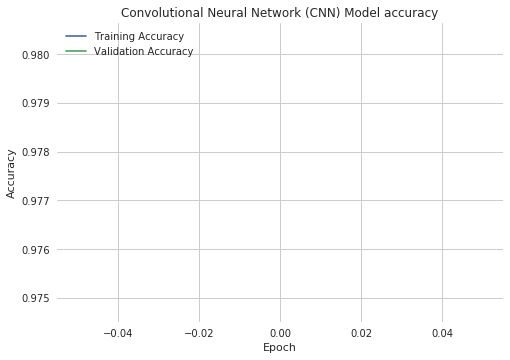

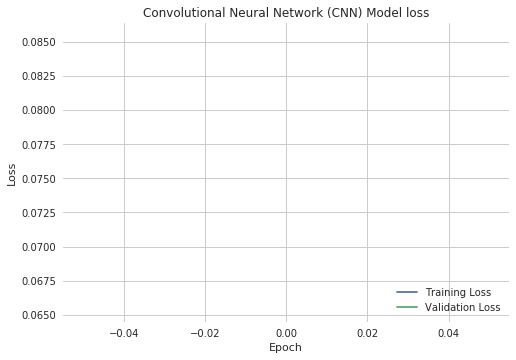

In [55]:
# Plot training & validation accuracy values
plt.plot(CNN_model_fit.history['acc'])
plt.plot(CNN_model_fit.history['val_acc'])
plt.title('Convolutional Neural Network (CNN) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_model_fit.history['loss'])
plt.plot(CNN_model_fit.history['val_loss'])
plt.title('Convolutional Neural Network (CNN) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## 3) Recurrent Neural Networks (RNNs)

In [0]:
RNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    #Fully-connected RNN where the output is to be fed back to input.
    SimpleRNN(25, return_sequences=True),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

RNN_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

### Visualize the Orchestrated RNN MODEL Architecture

In [58]:
RNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 128)          0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 200, 25)           3850      
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 25)           100       
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 25)           0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                1300      
__________

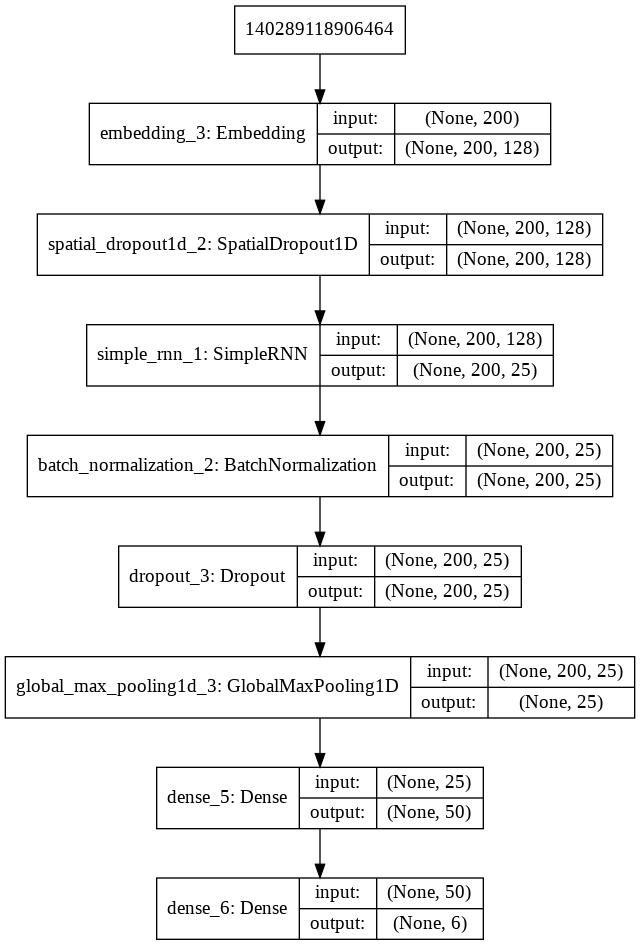

In [59]:
#plot the RNN model architecture

plot_model(RNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_model_plot.png')

In [60]:
RNN_model_fit = RNN_model.fit(X_tra, y_tra, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 338s 2ms/step - loss: 0.0875 - acc: 0.9725 - mean_pred: 0.0386 - fmeasure: 0.4954 - precision: 0.6669 - auroc: 0.8667 - recall: 0.4227 - val_loss: 0.0761 - val_acc: 0.9764 - val_mean_pred: 0.0497 - val_fmeasure: 0.5576 - val_precision: 0.9129 - val_auroc: 0.9358 - val_recall: 0.4060


### Evaluate the RNN Model accuracy of our trained model

In [61]:
RNN_train_score = RNN_model.evaluate(X_tra, y_tra, batch_size=batch_size2, verbose=1)
print('Train Loss:', RNN_train_score[0])
print('Train Accuracy:', RNN_train_score[1])

143613/143613 [==============================] - 54s 377us/step
Train Loss: 0.07175758135533704
Train Accuracy: 0.9782146053885864


### Evaluate the RNN accuracy base our test samples

In [62]:
RNN_test_score = RNN_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_test_score[0])
print('Test Accuracy:', RNN_test_score[1])

63930/63930 [==============================] - 24s 379us/step
Test Loss: 0.09222632848319548
Test Accuracy: 0.9723499710601241


### Plot Training & Validation Accuracy with the Loss values of the RNN Model

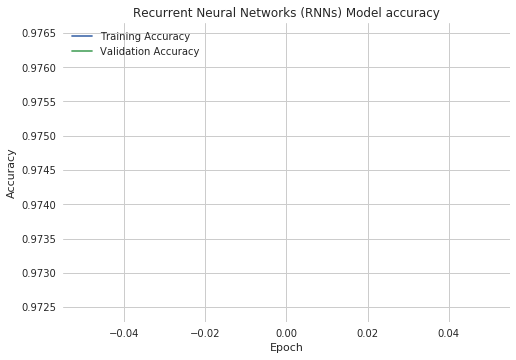

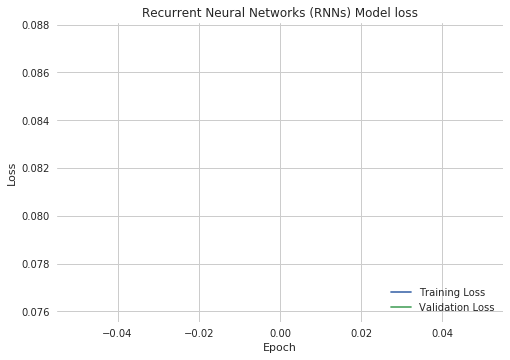

In [63]:
# Plot training & validation accuracy values
plt.plot(RNN_model_fit.history['acc'])
plt.plot(RNN_model_fit.history['val_acc'])
plt.title('Recurrent Neural Networks (RNNs) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(RNN_model_fit.history['loss'])
plt.plot(RNN_model_fit.history['val_loss'])
plt.title('Recurrent Neural Networks (RNNs) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## 4) Long Short-Term Memory (LSTM)

In [0]:
LSTM_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    LSTM(25, return_sequences=True),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [65]:
LSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])
LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 25)           15400     
_________________________________________________________________
batch_normalization_3 (Batch (None, 200, 25)           100       
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 25)           0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 25)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                1300      
__________

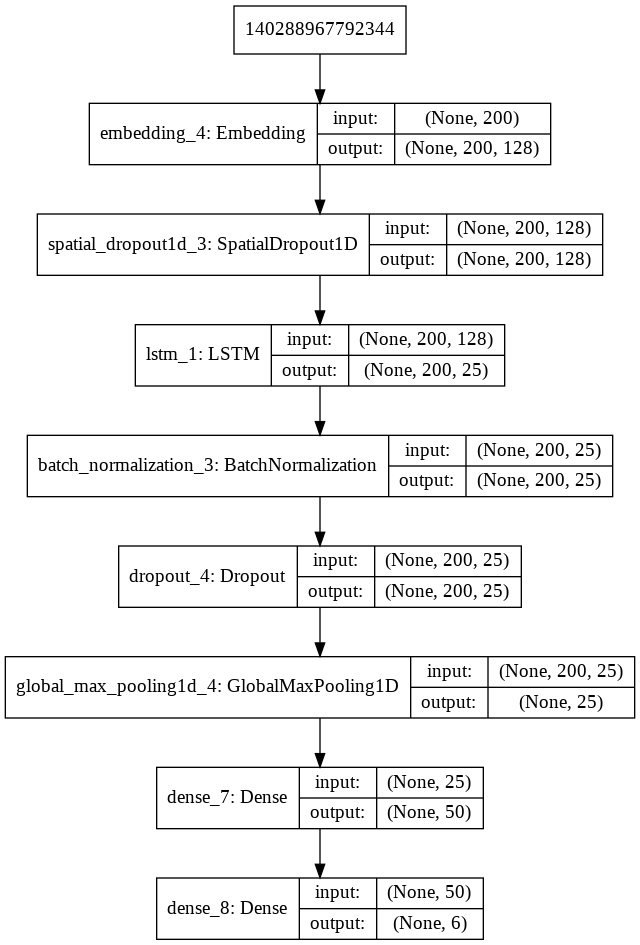

In [66]:
#plot the RNN model architecture

plot_model(LSTM_model, to_file='LSTM_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='LSTM_model_plot.png')

In [67]:
LSTM_model_fit = LSTM_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 534s 4ms/step - loss: 0.0709 - acc: 0.9758 - mean_pred: 0.0384 - fmeasure: 0.5961 - precision: 0.7194 - auroc: 0.9097 - recall: 0.5260 - val_loss: 0.0708 - val_acc: 0.9806 - val_mean_pred: 0.0583 - val_fmeasure: 0.6999 - val_precision: 0.8094 - val_auroc: 0.9570 - val_recall: 0.6227


### Evaluate the LSTM Model accuracy of our train and test accuracy

In [68]:

LSTM_train_score = LSTM_model.evaluate(X_tra, y_tra, batch_size=batch_size2, verbose=1)
print('Train Loss:', LSTM_train_score[0])
print('Train Accuracy:', LSTM_train_score[1])


LSTM_test_score = LSTM_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Train Loss:', LSTM_test_score[0])
print('Train Accuracy:', LSTM_test_score[1])

143613/143613 [==============================] - 85s 591us/step
Train Loss: 0.06756647031319737
Train Accuracy: 0.9821267401109678
63930/63930 [==============================] - 37s 586us/step
Train Loss: 0.09835448524966106
Train Accuracy: 0.9692189504297317


### Plot Training & Validation Accuracy with the Loss values of the LSTM Model

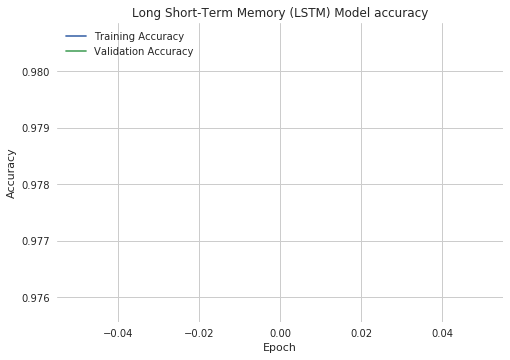

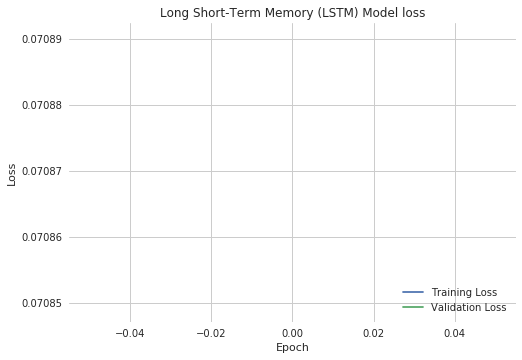

In [69]:
# Plot training & validation accuracy values
plt.plot(LSTM_model_fit.history['acc'])
plt.plot(LSTM_model_fit.history['val_acc'])
plt.title('Long Short-Term Memory (LSTM) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training<<<<<<<<<<<<<<<<<<<<l & validation loss values
plt.plot(LSTM_model_fit.history['loss'])
plt.plot(LSTM_model_fit.history['val_loss'])
plt.title('Long Short-Term Memory (LSTM) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## 5) Bidirectional Long Short_Term Memory (BidirectiOnal LSTM) 

In [0]:
Bil_LSTM_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
Bil_LSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

### Visualize the Orchestrated Bidirectional LSTM

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 50)           30800     
_________________________________________________________________
batch_normalization_4 (Batch (None, 200, 50)           200       
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
__________

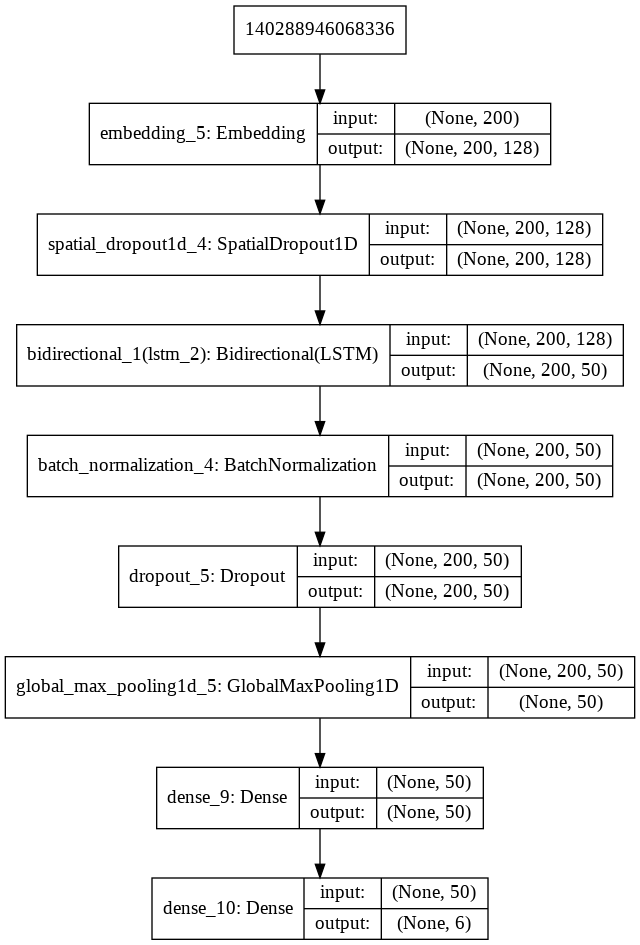

In [72]:
Bil_LSTM_model.summary()

#plot the RNN model architecture
plot_model(Bil_LSTM_model, to_file='Bil_LSTM_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='Bil_LSTM_model_plot.png')

In [73]:
Bil_LSTM_model_fit = Bil_LSTM_model.fit(X_tra, y_tra, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 1029s 7ms/step - loss: 0.0643 - acc: 0.9781 - mean_pred: 0.0377 - fmeasure: 0.6462 - precision: 0.7697 - auroc: 0.9274 - recall: 0.5758 - val_loss: 0.0673 - val_acc: 0.9807 - val_mean_pred: 0.0570 - val_fmeasure: 0.7094 - val_precision: 0.7919 - val_auroc: 0.9648 - val_recall: 0.6463


### Evaluate Bidirectional LSTM train and test score

In [0]:
#Train
Bil_train_score = Bil_LSTM_model.evaluate(X_tra, y_tra, batch_size=batch_size2, verbose=1)
print('Train Loss:', Bil_train_score[0])
print('Train Accuracy:', Bil_train_score[1])

#Test
Bil_test_score = Bil_LSTM_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', Bil_test_score[0])
print('Test Accuracy:', Bil_test_score[1])

143613/143613 [==============================] - 227s 2ms/step
Train Loss: 0.06276867138097283
Train Accuracy: 0.9827766362451998
11008/63930 [====>.........................] - ETA: 1:22

### Plot Training & Validation Accuracy with the Loss values of the Bidirectional LSTM Model

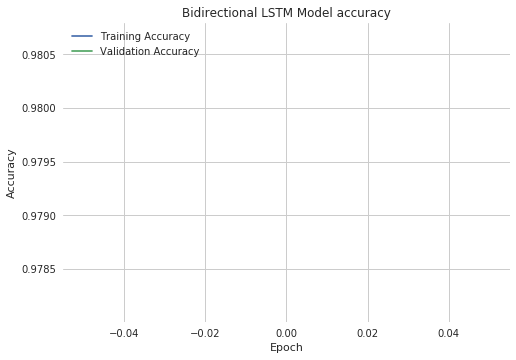

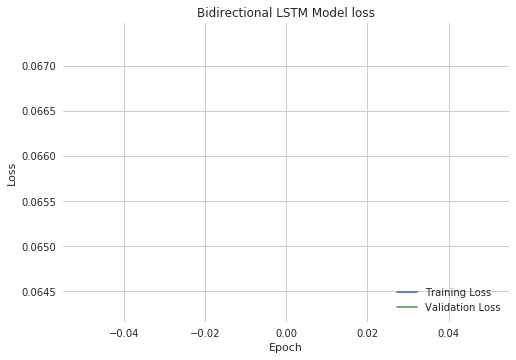

In [75]:
# Plot training & validation accuracy values
plt.plot(Bil_LSTM_model_fit.history['acc'])
plt.plot(Bil_LSTM_model_fit.history['val_acc'])
plt.title('Bidirectional LSTM Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Bil_LSTM_model_fit.history['loss'])
plt.plot(Bil_LSTM_model_fit.history['val_loss'])
plt.title('Bidirectional LSTM Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## 6) Gated Recurrent Unit (GRU)

In [0]:
sequence_input = Input(shape=(max_len, ))
model = Embedding(input_dim=max_features, output_dim=embedding_dims, trainable = False)(sequence_input)
model = SpatialDropout1D(0.2)(model)
model = GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1)(model)
model = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(model)
avg_pool = GlobalAveragePooling1D()(model)
max_pool = GlobalMaxPooling1D()(model)
model = concatenate([avg_pool, max_pool]) 
preds = Dense(6, activation="sigmoid")(model)
GRU_model = Model(sequence_input, preds)
GRU_model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])


### Visualize the Orchestrated GRU MODEL Architecture

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 200, 128)     25600000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 200, 128)     0           embedding_6[0][0]                
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 200, 128)     98688       spatial_dropout1d_5[0][0]        
__________________________________________________________________________________________________
conv1d_2 (

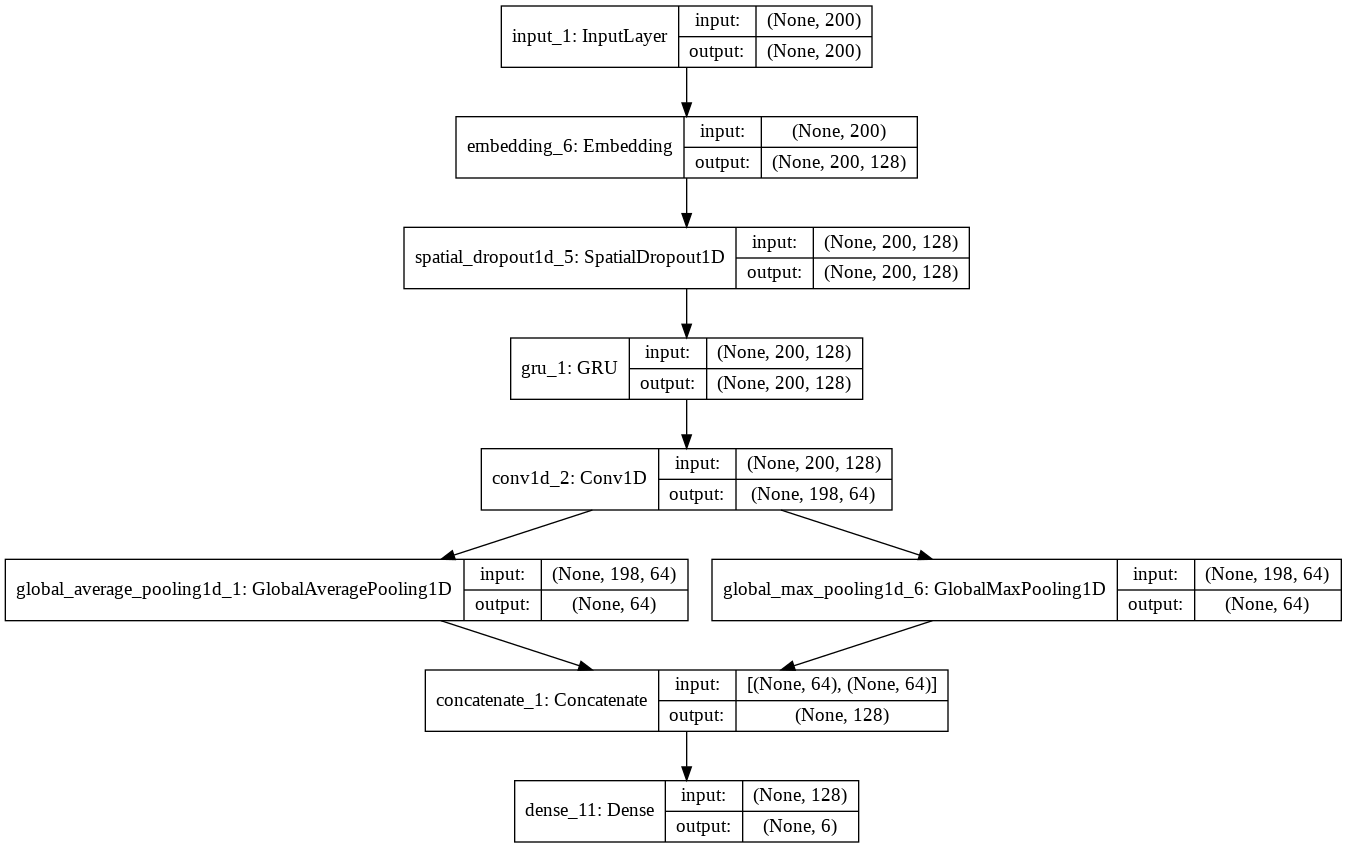

In [77]:
GRU_model.summary()

#plot the GRU model architecture

plot_model(GRU_model, to_file='GRU_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='GRU_model_plot.png')

In [78]:

GRU_model_fit = GRU_model.fit(X_tra, y_tra, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 989s 7ms/step - loss: 0.1427 - acc: 0.9619 - mean_pred: 0.0464 - fmeasure: 0.0187 - precision: 0.1405 - auroc: 0.7095 - recall: 0.0110 - val_loss: 0.1191 - val_acc: 0.9641 - val_mean_pred: 0.0467 - val_fmeasure: 0.1137 - val_precision: 0.6965 - val_auroc: 0.7970 - val_recall: 0.0630


### Evaluate the GRU Model train and test score

In [79]:
#Train
GRU_train_score = GRU_model.evaluate(X_tra, y_tra, batch_size=batch_size2, verbose=1)
print('Train Loss:', GRU_train_score[0])
print('Train Accuracy:', GRU_train_score[1])

#Test
GRU_test_score = GRU_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', GRU_test_score[0])
print('Test Accuracy:', GRU_test_score[1])

143613/143613 [==============================] - 266s 2ms/step
Train Loss: 0.11685972217079936
Train Accuracy: 0.9650333471426646
63930/63930 [==============================] - 118s 2ms/step
Test Loss: 0.1269867196411067
Test Accuracy: 0.9630194494874568


### Plot Training & Validation Accuracy with the Loss values of the GRU Model

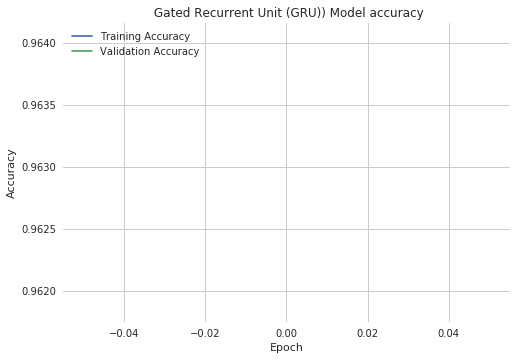

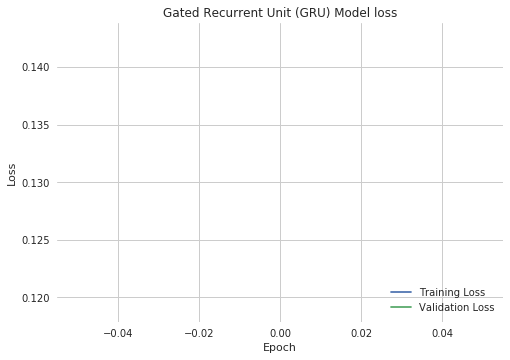

In [80]:
# Plot training & validation accuracy values
plt.plot(GRU_model_fit.history['acc'])
plt.plot(GRU_model_fit.history['val_acc'])
plt.title(' Gated Recurrent Unit (GRU)) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(GRU_model_fit.history['loss'])
plt.plot(GRU_model_fit.history['val_loss'])
plt.title('Gated Recurrent Unit (GRU) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## 7 )  Bidirectional Gated Recurrent Unit (Bidirecitonal GRU)

In [0]:
sequence_input = Input(shape=(max_len, ))
model = Embedding(input_dim=max_features, output_dim=embedding_dims, trainable = False)(sequence_input)
model = SpatialDropout1D(0.2)(model)
model = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(model)
model = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(model)
avg_pool = GlobalAveragePooling1D()(model)
max_pool = GlobalMaxPooling1D()(model)
model = concatenate([avg_pool, max_pool]) 
preds = Dense(6, activation="sigmoid")(model)
Bil_GRU_model = Model(sequence_input, preds)
Bil_GRU_model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

### Visualize the Orchestrated Bidirectional GRU Model Architecture



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 200, 128)     25600000    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_6 (SpatialDro (None, 200, 128)     0           embedding_7[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200, 256)     197376      spatial_dropout1d_6[0][0]        
__________________________________________________________________________________________________
conv1d_3 (

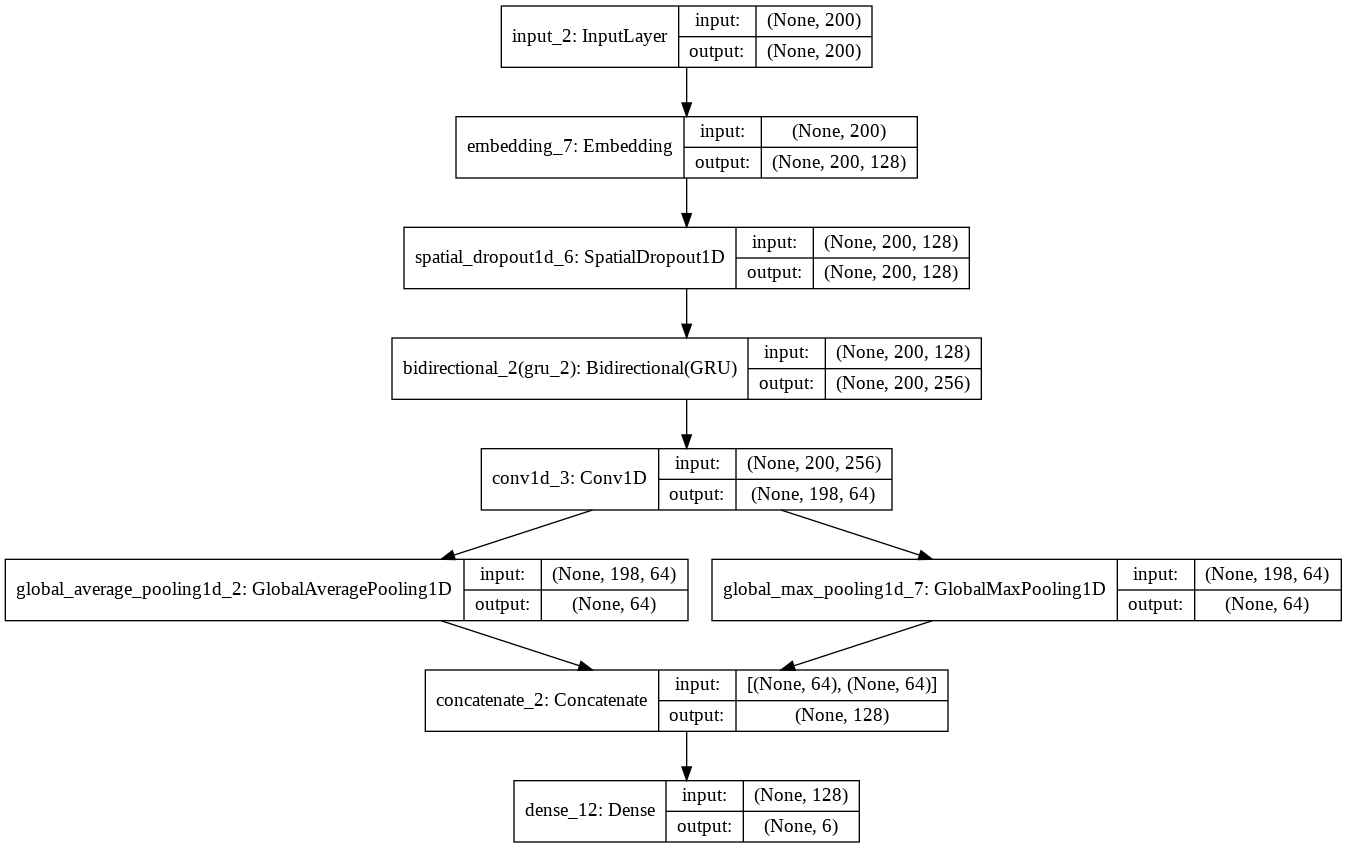

In [82]:
Bil_GRU_model.summary()

#plot the GRU model architecture

plot_model(Bil_GRU_model, to_file='Bil_GRU_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='Bil_GRU_model_plot.png')

In [83]:
Bil_GRU_model_fit = Bil_GRU_model.fit(X_tra, y_tra, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 1988s 14ms/step - loss: 0.1299 - acc: 0.9639 - mean_pred: 0.0444 - fmeasure: 0.1364 - precision: 0.4335 - auroc: 0.7416 - recall: 0.0869 - val_loss: 0.0983 - val_acc: 0.9699 - val_mean_pred: 0.0315 - val_fmeasure: 0.3475 - val_precision: 0.8661 - val_auroc: 0.8366 - val_recall: 0.2259


### Evaluate the GRU Model train and test score

In [84]:
#Train
Bil_GRU_train_score = Bil_GRU_model.evaluate(X_tra, y_tra, batch_size=batch_size2, verbose=1)
print('Train Loss:', Bil_GRU_train_score[0])
print('Train Accuracy:', Bil_GRU_train_score[1])

#Test
Bil_GRU_test_score = Bil_GRU_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', Bil_GRU_test_score[0])
print('Test Accuracy:', Bil_GRU_test_score[1])

143613/143613 [==============================] - 554s 4ms/step
Train Loss: 0.09680885314318022
Train Accuracy: 0.9706328867638289
63930/63930 [==============================] - 246s 4ms/step
Test Loss: 0.11095186574962913
Test Accuracy: 0.9669325862769209


### Plot Training & Validation Accuracy with the Loss values of the Bil GRU Model

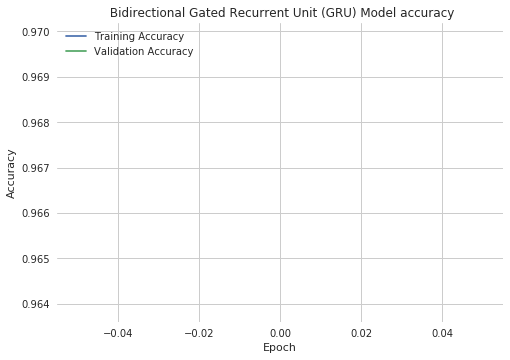

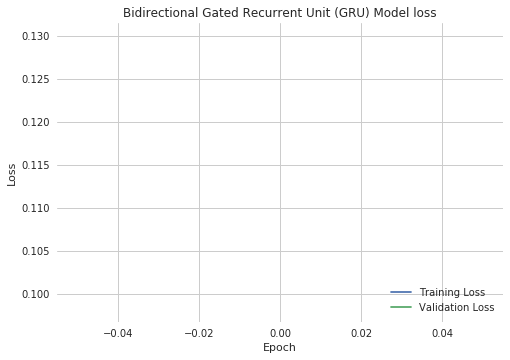

In [85]:
# Plot training & validation accuracy values
plt.plot(Bil_GRU_model_fit.history['acc'])
plt.plot(Bil_GRU_model_fit.history['val_acc'])
plt.title(' Bidirectional Gated Recurrent Unit (GRU) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Bil_GRU_model_fit.history['loss'])
plt.plot(Bil_GRU_model_fit.history['val_loss'])
plt.title('Bidirectional Gated Recurrent Unit (GRU) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

# Evaluation of Experiment Without Pre-trained Embedding

#### Computing the highest of the evaluation matrics (per model) 

In [86]:
trace = go.Table(
    header=dict(values=['Model', 'Loss', 'Accuracy', 'mean_pred', 'F-Measure', 'Precision', 'AUC', 'Recall'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['left'] * 5),
    cells=dict(values=[['Neural Network', 'CNN', 'RNNs', 'LSTM', ' Bidirectional LSTM', 'GRU', 'Bidirectional GRU'],
                       [
                        #Loss Evaluation
                        round(np.max(nn_model_fit.history['loss']), 3), round(np.max(CNN_model_fit.history['loss']), 3), round(np.max(RNN_model_fit.history['loss']), 3), 
                        round(np.max(LSTM_model_fit.history['loss']), 3), round(np.max(Bil_LSTM_model_fit.history['loss']), 3), round(np.max(GRU_model_fit.history['loss']), 3),
                        round(np.max(Bil_GRU_model_fit.history['loss']), 3)],
                        
                        #Accuracy Evaluation
                        [round(np.max(nn_model_fit.history['acc']), 3), round(np.max(CNN_model_fit.history['acc']), 3), round(np.max(RNN_model_fit.history['acc']), 3), 
                        round(np.max(LSTM_model_fit.history['acc']), 3), round(np.max(Bil_LSTM_model_fit.history['acc']), 3), round(np.max(GRU_model_fit.history['acc']), 3),
                        round(np.max(Bil_GRU_model_fit.history['acc']), 3)],
               
                        #mean_pred Evaluation
                        [round(np.max(nn_model_fit.history['mean_pred']), 3), round(np.max(CNN_model_fit.history['mean_pred']), 3), round(np.max(RNN_model_fit.history['mean_pred']), 3), 
                        round(np.max(LSTM_model_fit.history['mean_pred']), 3), round(np.max(Bil_LSTM_model_fit.history['mean_pred']), 3), round(np.max(GRU_model_fit.history['mean_pred']), 3),
                        round(np.max(Bil_GRU_model_fit.history['mean_pred']), 3)],
						
                        #F1-Measure Evaluation fmeasure
                        [round(np.max(nn_model_fit.history['fmeasure']), 3), round(np.max(CNN_model_fit.history['fmeasure']), 3), round(np.max(RNN_model_fit.history['fmeasure']), 3), 
                        round(np.max(LSTM_model_fit.history['fmeasure']), 3), round(np.max(Bil_LSTM_model_fit.history['fmeasure']), 3), round(np.max(GRU_model_fit.history['fmeasure']), 3),
                        round(np.max(Bil_GRU_model_fit.history['fmeasure']), 3)],
						             
                        #Precision Evaluation precision
                        [round(np.max(nn_model_fit.history['precision']), 3), round(np.max(CNN_model_fit.history['precision']), 3), round(np.max(RNN_model_fit.history['precision']), 3), 
                        round(np.max(LSTM_model_fit.history['precision']), 3), round(np.max(Bil_LSTM_model_fit.history['precision']), 3), round(np.max(GRU_model_fit.history['precision']), 3),
                        round(np.max(Bil_GRU_model_fit.history['precision']), 3)],
						
                        #ROC AUC Evaluation auroc
                        [round(np.max(nn_model_fit.history['auroc']), 3), round(np.max(CNN_model_fit.history['auroc']), 3), round(np.max(RNN_model_fit.history['auroc']), 3), 
                        round(np.max(LSTM_model_fit.history['auroc']), 3), round(np.max(Bil_LSTM_model_fit.history['auroc']), 3), round(np.max(GRU_model_fit.history['auroc']), 3),
                        round(np.max(Bil_GRU_model_fit.history['auroc']), 3)],
                       
                        #Recall Evaluation
                        [round(np.max(nn_model_fit.history['recall']), 3), round(np.max(CNN_model_fit.history['recall']), 3), round(np.max(RNN_model_fit.history['recall']), 3), 
                        round(np.max(LSTM_model_fit.history['recall']), 3), round(np.max(Bil_LSTM_model_fit.history['recall']), 3), round(np.max(GRU_model_fit.history['recall']), 3),
                        round(np.max(Bil_GRU_model_fit.history['recall']), 3)]
                       ],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['left'] * 5))

layout = dict(width=800, height=400)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(data, filename = 'multi-label_without_pre-trained_embedding_with the max of the evaluation matrics (per model) _table')

#### Computing the mean average of the evaluation matrics (per model) 

In [0]:
trace = go.Table(
    header=dict(values=['Model', 'Loss', 'Accuracy', 'mean_pred', 'F-Measure', 'Precision', 'AUC', 'Recall'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['left'] * 5),
    cells=dict(values=[['Neural Network', 'CNN', 'RNNs', 'LSTM', 'Bidirectional LSTM', 'GRU', 'Bidirectional GRU'],
                       [
                        #Loss Evaluation
                        round(np.mean(nn_model_fit.history['loss']), 3), round(np.mean(CNN_model_fit.history['loss']), 3), round(np.mean(RNN_model_fit.history['loss']), 3), 
                        round(np.mean(LSTM_model_fit.history['loss']), 3), round(np.mean(Bil_LSTM_model_fit.history['loss']), 3), round(np.mean(GRU_model_fit.history['loss']), 3),
                        round(np.mean(Bil_GRU_model_fit.history['loss']), 3)],
                        
                        #Accuracy Evaluation
                        [round(np.mean(nn_model_fit.history['acc']), 3), round(np.mean(CNN_model_fit.history['acc']), 3), round(np.mean(RNN_model_fit.history['acc']), 3), 
                        round(np.mean(LSTM_model_fit.history['acc']), 3), round(np.mean(Bil_LSTM_model_fit.history['acc']), 3), round(np.mean(GRU_model_fit.history['acc']), 3),
                        round(np.mean(Bil_GRU_model_fit.history['acc']), 3)],
               
                        #mean_pred Evaluation
                        [round(np.mean(nn_model_fit.history['mean_pred']), 3), round(np.mean(CNN_model_fit.history['mean_pred']), 3), round(np.mean(RNN_model_fit.history['mean_pred']), 3), 
                        round(np.mean(LSTM_model_fit.history['mean_pred']), 3), round(np.mean(Bil_LSTM_model_fit.history['mean_pred']), 3), round(np.mean(GRU_model_fit.history['mean_pred']), 3),
                        round(np.mean(Bil_GRU_model_fit.history['mean_pred']), 3)],
						
                        #F1-Measure Evaluation fmeasure
                        [round(np.mean(nn_model_fit.history['fmeasure']), 3), round(np.mean(CNN_model_fit.history['fmeasure']), 3), round(np.mean(RNN_model_fit.history['fmeasure']), 3), 
                        round(np.mean(LSTM_model_fit.history['fmeasure']), 3), round(np.mean(Bil_LSTM_model_fit.history['fmeasure']), 3), round(np.mean(GRU_model_fit.history['fmeasure']), 3),
                        round(np.mean(Bil_GRU_model_fit.history['fmeasure']), 3)],
						             
                        #Precision Evaluation precision
                        [round(np.mean(nn_model_fit.history['precision']), 3), round(np.mean(CNN_model_fit.history['precision']), 3), round(np.mean(RNN_model_fit.history['precision']), 3), 
                        round(np.mean(LSTM_model_fit.history['precision']), 3), round(np.mean(Bil_LSTM_model_fit.history['precision']), 3), round(np.mean(GRU_model_fit.history['precision']), 3),
                        round(np.mean(Bil_GRU_model_fit.history['precision']), 3)],
						
                        #ROC AUC Evaluation auroc
                        [round(np.mean(nn_model_fit.history['auroc']), 3), round(np.mean(CNN_model_fit.history['auroc']), 3), round(np.mean(RNN_model_fit.history['auroc']), 3), 
                        round(np.mean(LSTM_model_fit.history['auroc']), 3), round(np.mean(Bil_LSTM_model_fit.history['auroc']), 3), round(np.mean(GRU_model_fit.history['auroc']), 3),
                        round(np.mean(Bil_GRU_model_fit.history['auroc']), 3)],
                       
                        #Recall Evaluation
                        [round(np.mean(nn_model_fit.history['recall']), 3), round(np.mean(CNN_model_fit.history['recall']), 3), round(np.mean(RNN_model_fit.history['recall']), 3), 
                        round(np.mean(LSTM_model_fit.history['recall']), 3), round(np.mean(Bil_LSTM_model_fit.history['recall']), 3), round(np.mean(GRU_model_fit.history['recall']), 3),
                        round(np.mean(Bil_GRU_model_fit.history['recall']), 3)]
                       ],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['left'] * 5))

layout = dict(width=800, height=400)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(data, filename = 'multi-label_without_pre-trained_embedding_with the max of the evaluation matrics (per model) _table')

In [89]:
Image('multi-label_with the mean average of the evaluation matrics (per model) _table.png')

### Score confusion table

In [0]:
# concat all training, validation and testing accuracy scores
NN_Accuracy = ['Neural Network', 
               np.mean(nn_model_fit.history['acc']), 
               np.mean(nn_model_fit.history['val_acc']), 
               nn_test_score[1]]

CNN_Accuracy = ['Convolutional Neural Network (CNN)', 
                np.mean(CNN_model_fit.history['acc']), 
                np.mean(CNN_model_fit.history['val_acc']), 
                CNN_test_score[1]]

RNN_Accuracy = ['Recurrent Neural Networks (RNNs)', 
                np.mean(RNN_model_fit.history['acc']), 
                np.mean(RNN_model_fit.history['val_acc']), 
                RNN_test_score[1]]

LSTM_Accuracy = ['LSTM', 
                  np.mean(LSTM_model_fit.history['acc']), 
                  np.mean(LSTM_model_fit.history['val_acc']), 
                  LSTM_test_score[1]]

Bidirectional_LSTM_Accuracy = ['Bidirectional LSTM', 
                    np.mean(Bil_LSTM_model_fit.history['acc']), 
                    np.mean(Bil_LSTM_model_fit.history['val_acc']), 
                    Bil_LSTM_test_score[1]]

GRU_Accuracy = ['GRU', 
                    np.mean(GRU_model_fit.history['acc']), 
                    np.mean(GRU_model_fit.history['val_acc']), 
                    GRU_test_score[1]]

Bidirectional_GRU_Accuracy = ['Bidirectional GRU', 
                    np.mean(Bil_GRU_model_fit.history['acc']), 
                    np.mean(Bil_GRU_model_fit.history['val_acc']), 
                    Bil_GRU_test_score[1]]


# create dataframe
experimentalResult = pd.DataFrame([NN_Accuracy])
# append all other scores
experimentalResult = experimentalResult.append([NN_Accuracy, CNN_Accuracy, RNN_Accuracy, LSTM_Accuracy, Bidirectional_LSTM_Accuracy, CNN_Word2Vec_Accuracy, 
                                                GRU_Accuracy, Bidirectional_GRU_Accuracy])


# beautify the new dataframe
experimentalResult.columns = ['Model', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
experimentalResult.set_index(['Model'], inplace=True)
experimentalResult
print(experimentalResult)